In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Define the Cutout data generator
class CutoutGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def cutout(self, x, mask_size=16, p=0.5):
        # Generate a random mask
        mask = np.ones((x.shape[0], x.shape[1], x.shape[2]))
        mask_shape = (np.random.randint(0, x.shape[0]), np.random.randint(0, x.shape[1]), mask_size, mask_size)
        mask[mask_shape[0]:mask_shape[0]+mask_shape[2], mask_shape[1]:mask_shape[1]+mask_shape[3], :] = 0
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)
        # Apply the mask to the input image
        x = x * mask
        return x

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
#Converting the integer labels to one-hot encoded format
#This makes labels compatible with the model, and also provides an efficient way to represent the categorical data
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
#Example
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
#Performance optimization settings
at = tf.data.AUTOTUNE
#Batch size is an important hyperparameter that can affect the model's performance and training time
batch_len = 32
#It is used to resize the images to the same fixed size that can influence model's performance
img_size = 32

In [ ]:
def preprocess_image(image, label):
   #By resizing, the model is able to process all the images consistently and not be affected by the original size of the images. 
    image = tf.image.resize(image, (img_size, img_size))
    #Normalizing image pixel values to a small range(0,1) improves training stability.
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [ ]:
#train_ds_a & train_ds_b are created by shuffling the training data (x_train, y_train) and applying the preprocess_image function to each example. 
#Shuffling the data is important to improve the model's generalization.
train_ds_a_shuffle = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024))
train_ds_a=train_ds_a_shuffle.map(preprocess_image, num_parallel_calls=at)

train_ds_b_shuffle = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024))
train_ds_b=train_ds_b_shuffle.map(preprocess_image, num_parallel_calls=at)

#Loading (x_train, y_train) into a TensorFlow Dataset object.
train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

#Loading(x_test, y_test) into a TensorFlow Dataset object.
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#prefetch() is a method in TensorFlow Dataset that allows the pipeline to asynchronously fetch the next batch of data, while the current batch is being processed. 
train_ds_simple = (  
    train_ds_simple.map(preprocess_image, num_parallel_calls=at)
    .batch(batch_len)
    .prefetch(at)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_a, train_ds_b))
test_ds = (test_ds.map(preprocess_image, num_parallel_calls=at).batch(batch_len)
    .prefetch(at))

In [ ]:
def cutout(image, label, p=0.5, cutout_size=16):
    if np.random.random() > p:
        return image, label
    h, w, _ = image.shape
    x = np.random.randint(w)
    y = np.random.randint(h)
    x1 = np.clip(x - cutout_size // 2, 0, w)
    y1 = np.clip(y - cutout_size // 2, 0, h)
    x2 = np.clip(x + cutout_size // 2, 0, w)
    y2 = np.clip(y + cutout_size // 2, 0, h)
    image[y1:y2, x1:x2] = 0
    return image, label


In [ ]:
def cutout(image, label):
    image, label = image
    h, w, _ = image.shape
    cut_size = int(h * 0.1)
    

In [ ]:
def cutout(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

In [ ]:
@tf.function
def cutout(image,label, size=12, n_squares=1):
    h, w, channels = image[0].shape 
    new_image = image[0]
    for _ in range(n_squares):
        y = tf.random.uniform((1,), minval=0, maxval=h, dtype=tf.int32)
        x = tf.random.uniform((1,), minval=0, maxval=w, dtype=tf.int32)
        y1 = tf.clip_by_value(y - size // 2, 0, h)
        y2 = tf.clip_by_value(y + size // 2, 0, h)
        x1 = tf.clip_by_value(x - size // 2, 0, w)
        x2 = tf.clip_by_value(x + size // 2, 0, w)
        new_image = tf.tensor_scatter_nd_update(new_image, [[y1, x1, y2, x2]], tf.zeros((size, size, channels)))
    return new_image


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
train_ds

<ZipDataset element_spec=((TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None)), (TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None)))>

Images with cutout:


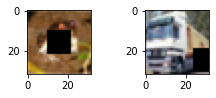

In [ ]:
print("Images with cutout:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(cutout(x_train[i]))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CutoutGenerator(ImageDataGenerator):
    def __init__(self, cutout_size=12, cutout_n_squares=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_size = cutout_size
        self.cutout_n_squares = cutout_n_squares
    
    def cutout(self, x, y):
        x = cutout(x, size=self.cutout_size, n_squares=self.cutout_n_squares)
        return x, y

In [ ]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
# Instantiate the Cutout generator
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
cutout_gen = CutoutGenerator(cutout_size=12, cutout_n_squares=1)
cutout_gen.fit(x_train)
model.fit(cutout_gen.flow(x_train, y_train, batch_size=256), epochs=15, validation_data=(x_test, y_test))
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
196/196 [==============================] - 654s 3s/step - loss: 1.7009 - accuracy: 0.4435 - val_loss: 2.4899 - val_accuracy: 0.2649
Epoch 2/15
196/196 [==============================] - 639s 3s/step - loss: 1.2948 - accuracy: 0.5900 - val_loss: 1.8803 - val_accuracy: 0.4372
Epoch 3/15
196/196 [==============================] - 644s 3s/step - loss: 1.1097 - accuracy: 0.6564 - val_loss: 1.5623 - val_accuracy: 0.5401
Epoch 4/15
196/196 [==============================] - 640s 3s/step - loss: 0.9779 - accuracy: 0.7067 - val_loss: 1.5921 - val_accuracy: 0.5578
Epoch 5/15
196/196 [==============================] - 657s 3s/step - loss: 0.8749 - accuracy: 0.7425 - val_loss: 1.3087 - val_accuracy: 0.6084
Epoch 6/15
196/196 [==============================] - 654s 3s/step - loss: 0.7872 - accuracy: 0.7749 - val_loss: 1.1410 - val_accuracy: 0.6624
Epoch 7/15
196/196 [==============================] - 648s 3s/step - loss: 0.7129 - accuracy: 0.8026 - val_loss: 1.3707 - val_accuracy: 0.6271

In [ ]:

# Instantiate the Cutout generator
cutout_gen = CutoutGenerator()

# Create the ResNet model
resnet = ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)

# Compile the model
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the Cutout generator
resnet.fit(cutout_gen.flow(x_train, y_train, batch_size=32), epochs=15, validation_data=(x_test, y_test))

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

NameError: ignored